In [1]:
from anisotropy.database import Database, tables
import pathlib
import peewee as pw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
db = Database(pathlib.Path("anisotropy.db").resolve())
savefig = False
execution = 5

In [3]:
def load_data(execution: int, field: str):
    if not db.getExecution(execution):
        print("Execution not found")

    for model in db.tables:
        try:
            column = getattr(model, field)
        
        except AttributeError:
            pass

        else:
            break

    query = model.select(tables.Shape.alpha, column, tables.Shape.direction, tables.Shape.label)
    idn = db.tables.index(model)

    for table in reversed(db.tables[ :idn]):
        query = query.join(table, pw.JOIN.LEFT_OUTER)
        
    query = query.switch(tables.Shape)
    query = query.where(
        tables.Shape.exec_id == execution,
    #    tables.Shape.label == structure,
    )
    query = query.order_by(tables.Shape.label, tables.Shape.direction, tables.Shape.alpha)

    with db:
        if query.exists():
            table = []
            for row in query.dicts():
                for k in row.keys():
                    if type(row[k]) == list:
                        row[k] = str(row[k])

                table.append(row)
        
        else:
            table = None

    if table is None:
        print("Results not found")

    else:
        return pd.DataFrame(table)


def nanmean(arr):
    temp = arr.copy()

    for n, item in enumerate(temp):
        if np.all(np.isnan(item)):
            
            vals = temp[n - 1 : n + 2]

            if np.sum(~np.isnan(vals)) <= 1:
                vals = temp[n - 2 : n + 3]

            temp[n] = vals[~np.isnan(vals)].mean()

    return temp

def filter_group(arr, nan = True, qhigh = True):
    temp = arr.copy()
    check = True
    quan = np.quantile(temp[~np.isnan(temp)], 0.97)
    limit = 1000

    while check:
        if nan and np.any(np.isnan(temp)):
            temp = nanmean(temp)
            check = True
        
        elif qhigh and np.any(quan < temp):
            temp[quan < temp] = np.nan
            check = True

        else:
            check = False 
        
        if limit <= 0:
            break

        else:
            limit -= 1

    return temp

Porosity

/tmp/ipykernel_53258/3263217096.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  simple = df[df.label == "simple"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
/tmp/ipykernel_53258/3263217096.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bodyCentered = df[df.label == "bodyCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
/tmp/ipykernel_53258/3263217096.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  faceCentered = df[df.label == "faceCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()


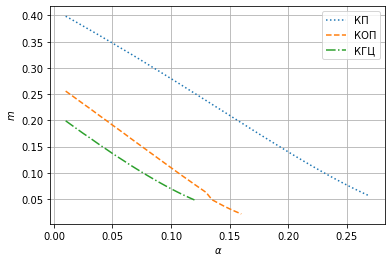

In [4]:
df = load_data(execution, "porosity")
alpha = df["alpha"].unique()
simple = df[df.label == "simple"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
bodyCentered = df[df.label == "bodyCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()
faceCentered = df[df.label == "faceCentered"][df.direction == "[0.0, 0.0, 1.0]"]["porosity"].to_numpy()

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(alpha, np.pad(simple, (0, alpha.size - simple.size), 'constant', constant_values = np.nan), ":", label = "КП")
ax.plot(alpha, np.pad(bodyCentered, (0, alpha.size - bodyCentered.size), 'constant', constant_values = np.nan), "--", label = "КОП")
ax.plot(alpha, np.pad(faceCentered, (0, alpha.size - faceCentered.size), 'constant', constant_values = np.nan), "-.", label = "КГЦ")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$m$")
plt.show()

if savefig:
    fig.savefig("porosity-rounded.png")

Simple structure

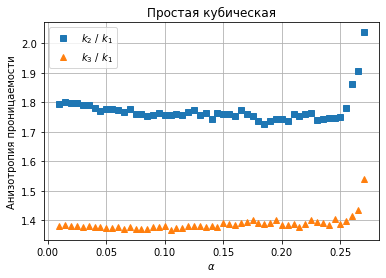

In [5]:
df = load_data(execution, "flowRate")
simple = df[df.label == "simple"].groupby(df.direction)
alpha = simple.get_group("[0.0, 0.0, 1.0]")["alpha"].to_numpy()

anisotropy_21 = 2 * simple.get_group('[0.0, 0.0, 1.0]')["flowRate"].to_numpy() / simple.get_group('[1.0, 0.0, 0.0]')["flowRate"].to_numpy()
anisotropy_31 = 2 * simple.get_group('[1.0, 1.0, 1.0]')["flowRate"].to_numpy() / simple.get_group('[1.0, 0.0, 0.0]')["flowRate"].to_numpy()
#poly = np.polynomial.Polynomial.fit(alpha, anisotropy_21, 1)

anisotropy_21 = filter_group(anisotropy_21, qhigh = False)
anisotropy_31 = filter_group(anisotropy_31, qhigh = False)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(alpha, anisotropy_21, "s", label = "$k_2$ / $k_1$")
ax.plot(alpha, anisotropy_31, "^", label = "$k_3$ / $k_1$")
#ax.plot(alpha, poly(alpha), "-")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
plt.ylabel("Анизотропия проницаемости")
plt.title("Простая кубическая")
plt.show()

if savefig:
    fig.savefig("anisotropy-simple.png")

Body-centered structure

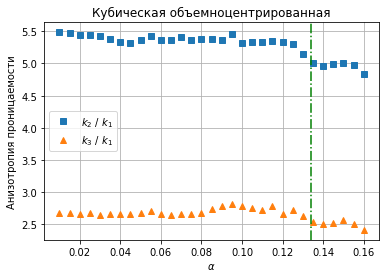

In [6]:
df = load_data(execution, "flowRate")
bodyCentered = df[df.label == "bodyCentered"].groupby(df.direction)
alpha = bodyCentered.get_group("[0.0, 0.0, 1.0]")["alpha"].to_numpy()

anisotropy_21 = 2 * bodyCentered.get_group('[0.0, 0.0, 1.0]')["flowRate"].to_numpy() / bodyCentered.get_group('[1.0, 0.0, 0.0]')["flowRate"].to_numpy()
anisotropy_31 = 2 * bodyCentered.get_group('[1.0, 1.0, 1.0]')["flowRate"].to_numpy() / bodyCentered.get_group('[1.0, 0.0, 0.0]')["flowRate"].to_numpy()

anisotropy_21 = filter_group(anisotropy_21)
anisotropy_31 = filter_group(anisotropy_31)
#poly = np.polynomial.Polynomial.fit(alpha, anisotropy_21, 10)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(alpha, anisotropy_21, "s", label = r"$k_2$ / $k_1$")
ax.plot(alpha, anisotropy_31, "^", label = r"$k_3$ / $k_1$")
ax.axvline(0.134, linestyle = "-.", color = "green")
#ax.plot(alpha, poly(alpha), "-")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
plt.ylabel("Анизотропия проницаемости")
plt.title("Кубическая объемноцентрированная")

if savefig:
    fig.savefig("anisotropy-bodycentered.png")

Face-centered structure

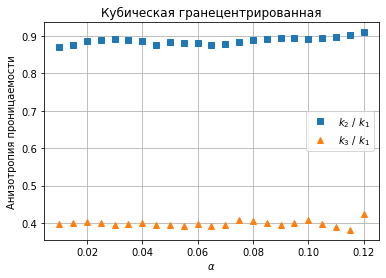

In [7]:
df = load_data(execution, "flowRate")
faceCentered = df[df.label == "faceCentered"].groupby(df.direction)
alpha = faceCentered.get_group("[0.0, 0.0, 1.0]")["alpha"].to_numpy()

anisotropy_21 = 2 * faceCentered.get_group('[0.0, 0.0, 1.0]')["flowRate"].to_numpy() / faceCentered.get_group('[1.0, 0.0, 0.0]')["flowRate"].to_numpy()
anisotropy_31 = 2 * faceCentered.get_group('[1.0, 1.0, 1.0]')["flowRate"].to_numpy() / faceCentered.get_group('[1.0, 0.0, 0.0]')["flowRate"].to_numpy()

anisotropy_21 = filter_group(anisotropy_21)
anisotropy_31 = filter_group(anisotropy_31)
#poly = np.polynomial.Polynomial.fit(alpha, anisotropy_21, 10)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(alpha, anisotropy_21, "s", label = r"$k_2$ / $k_1$")
ax.plot(alpha, anisotropy_31, "^", label = r"$k_3$ / $k_1$")
#ax.plot(alpha, poly(alpha), "-")
plt.legend()
plt.grid(True)
plt.xlabel(r"$\alpha$")
plt.ylabel("Анизотропия проницаемости")
plt.title("Кубическая гранецентрированная")
plt.show()

if savefig:
    fig.savefig("anisotropy-facecentered.png")